# Mean Field Q-learning (MFQ)
See < http://proceedings.mlr.press/v80/yang18d/yang18d.pdf >

$$ Q_j(s,a) = \frac{1}{N_j} \sum_{k \in N(j)} Q_j(s,a_j,a_k)$$
where $N(j)$ is the index set of the nearest neighbors of agent $j$

$a_{-j}$ is the _mean_ action of the neighbors of agent $j$


##### Why do we need mean field approximation?

Because the joint action space grows exponentially with the number of agents _N_. Why does it grow exponentially? Because the joint-action space of _N_ agents is the tensor product of each of their individual action spaces, and the tensor product space grows exponentially in the size of _N_.

Concretely, imagine an environment where each agent has 10 possible actions. We encode this action
as a one-hot vector of length 10. So with 1 agent the action-space is $\mathbb{R}^{10}$.

Now how do we encode the joint-action space of two agents? We can't just concatenate two one-hot encoded vectors together into a single 20-element vector because this would be ambiguous. Well, we possibly could if we used a convolutional neural network, because then spatial information could be learned and the neural network might be able to learn that each 10 element segment represents an agent, but even this probably wouldn't work very well. 

The only way to completely unambiguously represent an action is with a one-hot vector since each action is orthogonal to each other. Thus, with two agents, we'd need $\mathbb{R}^{10}\otimes \mathbb{R}^{10} = \mathbb{R}^{10 \times 10} = \mathbb{R}^{100}$. So the unique way to represent the joint-action space of 2 agents requires a 100-element one-hot vector. And the size of the joint-action space of 3 agents is $\mathbb{R}^{10}\otimes \mathbb{R}^{10} \otimes \mathbb{R}^{10} = \mathbb{R}^{1000}$. The pattern is that of exponential growth as the number of agents increases, i.e. the joint-action space size is $10^N$.

This is obviously inctractable as we get to large values of N, so we need someway to approximate the joint-action space in a lower dimensional (with sub-exponential growth) manner. One way is factorize the joint-action space and train a Q-learner for each factor. If we factorize it completely such that each factor is the sie of an individual agent's action space, we get independent Q-learning (IL-Q) because each agent $j$ is modeled as $Q_j(s,a_j)$, hence each agent only considers the current state of the environment and not the activity of the other agents. The actions by the other agents essentially gets interpreted as noise in the environment. 

A sufficiently powerful neural network may be able to make some sense out of that noise but even so, having _N_ really huge neural networks is not efficient. The network would have to be powerful because when you're not using one-hot encodings, the input space may be smaller (in terms of encoding) but the network has to learn how to separate joint actions in this space and that is hard because each joint action vector is only very slightly different in the space whereas if you use one-hot encoding each joint-action is orthogonal to each other so the network doesn't have to do anywork to separate the joint-actions.

A better approach is to factorize the action space into _neighborhoods_ where nearby agents are collected into (possibly overlapping) neighborhoods such that each agent $j$ is represented as $Q_j(s,a_j,n_j)$ where $n_j$ is the joint-action space of the agents in the neighborhood of agent $j$. If we set a maximal size to each neighborhood, say the nearest 3 agents, then the size of the joint-action space of the neighborhood will never be more than $\mathbb{R}^{1000}$, and then each new agent will just get added to a new constant-size neighborhood.

But we can do even better. Because exponential growth happens _really really_ fast, e.g. a neighborhood with 3 agents is a 1000-element vector which seems reasonable, but even just adding 1 more agent jumps to a 10,000-element vector which is quickly getting unreasonable. So we have to keep our neighborhoods really small, which isn't all that much better than IL-Q.

Instead of using any sort of joint-action space, we can instead treat all the other agents in a neighborhood as a single agent and simply take the _mean_ of all their actions. So rather than having a giant joint-action space vector that can perfectly represent the combination of actions of N agents, we instead take the actions of each agent in the neighorbood and add them together and divide by the number of agents to get a _mean_ action vector that is only the size of a single agent's action space, in our example a 10-element vector. Except now it's no longer a one-hot encoded vector but rather a dense vector that could be intepreted as an empirical probability distribution over the "mean field agent."

Now each agent's neighborhood can be arbitrarily large (but you still want to keep it small to avoid contributions from very distant and unimportant agents) but the resulting mean-field action space will always be very small. It turns out that, despite losing a lot of information in the approximation, this approach works surprisingly well in a lot of situations where only local interactions are important.

Ising Model:  
Grid of NxN agents with two states up or down. Energy of agent determined by degree of coherence between its state and its nearest neighbors.
Probability $\beta$ that the agent's agent will be randomly flipped where $\beta$ is $\text{sigmoid}(\text{Temperature})$ such that high temperature leads to high probability of random corruption.

The following first example of an Ising Model uses Independent Q-learning (IQL) that treats the other agents as part of the environment, and demonstrates its limitations (it does not optimally solve the 1D Ising Model).

The difference between IQL with multiple agents embedded as part of the environment and true Multi-Agent Reinforcement Learning (MARL) is that in IQL, each agent only reacts to what happens in the environment. Each agent may learn to predict the evolution of the environment, but in order to effectively do that, each agent would have to learn the policies of every other agent, which is intractable in high-dimensions. Moreover, when each agent's value function and policy are learning from the dynamics of the environment, and the value function of the environment is conventionally considered to be a stationary distribution. However in the true MARL case, the value function of the state depends on the actions of every other agent, leading to a non-stationary value distribution which causes an unstable learning process.

In mean field reinforcement learning (MFRL), we tackle this problem by allowing each agent to model the environment while also considering the actions of only its nearest neighboring agents. Thus it must learn to predict the behavior of the environment and the policies of its neighoring agents, which is tractable and also allows each agent to anticipate the agents of its neighboring agents _before_ they have actually committed any actions.

#### Factorized (Neighborhood) Q-learning

To introduce multi-agent reinforcement learning and to later contrast with real mean-field q-learning (MF-Q), we will first implement a factorized q-learning technique (F-Q) on a 1D Ising Model. F-Q works fairly well here since the joint-action space over 2 agents is very tractable. If we use a 3D+ Ising Model, however, the minimal neighborhood is too large and we must resort to a mean field approach.

In [2]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib import cm

In [3]:
def init_grid(size=(10,)):
    grid = torch.randn(*size)
    grid[grid > 0] = 1
    grid[grid <= 0] = 0
    grid = grid.byte()
    return grid

In [4]:
def get_reward(s,a):
    r = -1
    for i in s:
        if i == a:
            r += 0.9
    r *= 2.
    return r

In [5]:
def gen_params(N,size):
    """
    Generates a list of randomly initialized parameter vectors for use in an MLP
    `N` is the number of vectors to generate
    `size` is the length of each vector
    """
    ret = []
    for i in range(N):
        vec = torch.randn(size) / 10.
        vec.requires_grad = True
        ret.append(vec)
    return ret

In [6]:
def qfunc(s,theta,layers=[(4,20),(20,2)],afn=torch.tanh):
    """
    Q-function, implemented as simple 2-layer MLP.
    Expects state `s` which is the binary vector of neighbors states and parameter vector `theta`
    with associated keywd param `layers` which is a list of the form [(s1,s2)...] that 
    indicates the shape of the parameter matrix for each layer.
    
    Returns q-values for each possible action up/down
    """
    l1n = layers[0]
    l1s = np.prod(l1n)
    theta_1 = theta[0:l1s].reshape(l1n)
    l2n = layers[1]
    l2s = np.prod(l2n)
    theta_2 = theta[l1s:l2s+l1s].reshape(l2n)
    bias = torch.ones((1,theta_1.shape[1]))
    l1 = s @ theta_1 + bias#1 x N @ N x 10 = 1x10
    l1 = torch.nn.functional.elu(l1)
    l2 = afn(l1 @ theta_2) #1x10 @ 10 x 2
    return l2.flatten()

In [7]:
def get_substate(b):
    # b is a binary digit indicating up (1) or down (0)
    s = torch.zeros(2)
    if b > 0: #Create one-hot state vector where 0,1 is up and 1,0 is down
        s[1] = 1
    else:
        s[0] = 1
    return s
def joint_state(s):
    """
    This takes two binary values indicating the up(1)/down(0) states of the two nearest neighbors
    of an agent and returns the one-hot encoded joint action space
    s: vector of binary values
    s[0] = left neighbor
    s[1] = right neighbor
    """
    s1_ = get_substate(s[0])
    s2_ = get_substate(s[1])
    # 1,0,0,0 left up, right up
    # 0,1,0,0 left up, right down
    # 0,0,1,0 left down, right up
    # 0,0,0,1 left down, right down
    ret = (s1_.reshape(2,1) @ s2_.reshape(1,2)).flatten()
    return ret

tensor([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1],
       dtype=torch.uint8) tensor(9)


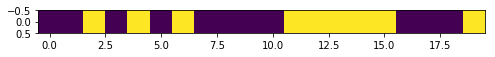

In [82]:
#params
plt.figure(figsize=(8,5))
size = (20,)
hid_layer = 20
params = gen_params(size[0],4*hid_layer+hid_layer*2) #store parameter vector thetas for each Q-function
grid = init_grid(size=size) #initialize grid
grid_ = grid.clone() #grid clone
print(grid,grid.sum())
plt.imshow(np.expand_dims(grid,0))

In [83]:
epochs = 200
lr = 0.001
losses = [[] for i in range(size[0])]
for i in range(epochs): #loop through epochs
    for j in range(size[0]): #loop through agents
        l = j - 1 if j - 1 >= 0 else size[0]-1 #loop around to end
        r = j + 1 if j + 1 < size[0] else 0 #loop around to beginning
        state_ = grid[[l,r]] #neighbor is neighbor to right and left
        #print(state_)
        state = joint_state(state_)
        qvals = qfunc(state.float().detach(),params[j],layers=[(4,hid_layer),(hid_layer,2)])
        #qvals[0] is for 'down' and qvals[1] is for up
        qmax = torch.argmax(qvals,dim=0).detach().item()
        #if i % 50==0: print(qmax)
        action = int(qmax)
        #print(action,qvals)
        grid_[j] = action
        reward = get_reward(state_.detach(),action)
        with torch.no_grad():
            target = qvals.clone()
            target[action] = reward#int(np.random.randn(1))#
        loss = torch.sum(torch.pow(qvals - target,2))
        losses[j].append(loss.detach().numpy())
        loss.backward()
        #SGD
        with torch.no_grad():
            params[j] = params[j] - lr * params[j].grad
        params[j].requires_grad = True
    with torch.no_grad():
        grid.data = grid_.data
    mean_running_loss = np.array(losses)[:,-50:-1].mean()
    if mean_running_loss < 0.4:
        print("Converged after {} epochs".format(i,))
        break

/Users/brandonbrown/anaconda3/envs/deeprl/lib/python3.6/site-packages/ipykernel/__main__.py:31: RuntimeWarning: Mean of empty slice.
/Users/brandonbrown/anaconda3/envs/deeprl/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.uint8) tensor(5)


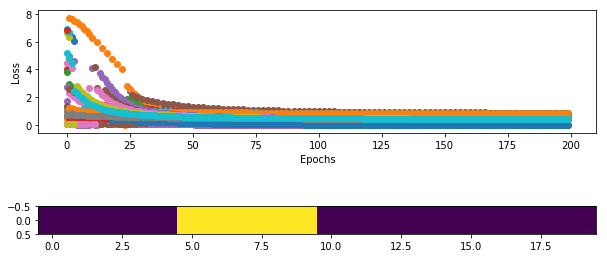

In [84]:
fig,ax = plt.subplots(2,1)
fig.set_size_inches(10,5)
for i in range(size[0]):
    ax[0].scatter(np.arange(len(losses[i])),losses[i])
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
print(grid,grid.sum())
ax[1].imshow(np.expand_dims(grid,0))

### Mean Field Q-learning (no target network)
2D Ising Model

One problem with the simplified F-Q approach from above is that each agent based its decision on the previous action of its neighbors, but the whole promise of true multi agent reinforcement learning (e.g. _not_ IL-Q) is to be able to update ones actions based on what other agents are _simultaneously_ doing, and therefore add an element of active modeling of other agents behavior in real-time. The last approach we tried was based on lagged actions.

Let's take the standpoint of a single agent. My current policy depends on the current actions of my neighbors, but the current actions of my neighbors depend on _my_ current actions. It seems like we've setup an infinite loop, how do we get out and actually take actions after a finite period of deliberation?

Well, we can simply alternate a few times between imagining an action based on my current policy (which depends on the current actions of my neighbors), and then once I've imagined my action that influences the policy of my neighbors, who also take imagined actions, and then I update my imagined action based on their changes. We just repeat this process a finite number of steps, and eventually we will converge on a stable configuration. Then, I will actually take my imagined action in the real environment.

In [8]:
from collections import deque
from random import shuffle

In [9]:
def softmax_policy(qvals,temp=0.9):
    #also called boltzmann policy
    soft = torch.exp(qvals/temp) / torch.sum(torch.exp(qvals/temp))
    action = torch.multinomial(soft,1)
    return action

In [11]:
def get_coords(grid,j):
    x = int(np.floor(j / grid.shape[0]))
    y = int(j - x * grid.shape[0])
    return x,y

def get_reward_2d(action,action_mean):
    assert action.shape[0] == 2
    assert action_mean.shape[0] == 2
    #r = torch.pow(2,-torch.sum(torch.pow(action - action_mean,2)))
    #r = np.power(2,-np.linalg.norm(action.detach().numpy()-action_mean.detach().numpy()))
    r = (action*(action_mean-action/2)).sum()/action.sum()
    return torch.tanh(5 * r)

def mean_action(grid,j):
    """
    This function accepts an agent index `j` and 
    returns that agent's 8 nearest (surrounding) neighbord's mean action on the grid
    """
    #convert vectorized index j into grid coordinates x,y, where 0,0 is top left
    x,y = get_coords(grid,j)
    action_mean = torch.zeros(2)
    for i in [-1,0,1]:
        for k in [-1,0,1]:
            if i == k == 0:
                continue
            x_,y_ = x + i, y + k
            x_ = x_ if x_ >= 0 else grid.shape[0] - 1
            y_ = y_ if y_ >= 0 else grid.shape[1] - 1
            x_ = x_ if x_ <  grid.shape[0] else 0
            y_ = y_ if y_ < grid.shape[1] else 0
            #print(x_,y_)
            cur_n = grid[x_,y_]
            s = get_substate(cur_n)
            action_mean += s
    action_mean /= action_mean.sum()
    return action_mean

tensor(53)


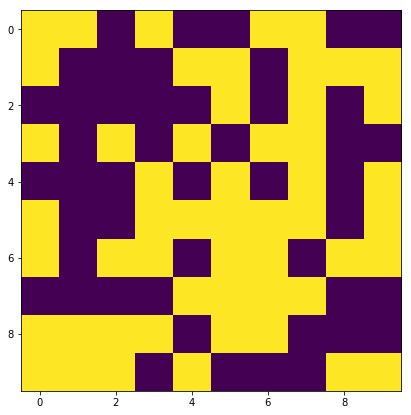

In [168]:
#params
plt.figure(figsize=(7,7))
size = (10,10)
J = np.prod(size) #num agents
hid_layer = 10
layers = [(2,hid_layer),(hid_layer,2)]
params = gen_params(1,2*hid_layer+hid_layer*2) #store parameter vector thetas for each Q-function
grid = init_grid(size=size) #initialize grid
grid_ = grid.clone() #grid clone
grid__ = grid.clone() #second grid clone
plt.imshow(grid)
print(grid.sum())

In [169]:
%%time
epochs = 100
lr = 0.0001 #1e-5
num_iter = 3
losses = [ [] for i in range(size[0])]
replay_size = 50
replay = deque(maxlen=replay_size)
batch_size = 10
gamma = 0.9
losses = [[] for i in range(J)]
for i in range(epochs): #loop through epochs
    act_means = torch.zeros((J,2))
    q_next = torch.zeros(J) #max qvals of subsequent state
    for m in range(num_iter): #alternate between updating mean action and policies a few times
        for j in range(J): #loop through agents
            action_mean = mean_action(grid_,j).detach()
            act_means[j] = action_mean.clone()
            qvals = qfunc(action_mean.detach(),params[0],layers=layers)
            action = softmax_policy(qvals.detach(),temp=0.5)
            #action = torch.argmax(qvals.detach())
            grid__[get_coords(grid_,j)] = action
            q_next[j] = torch.max(qvals).detach()
        grid_.data = grid__.data
    grid.data = grid_.data #take the actions in the real environment
    actions = torch.stack([get_substate(a.item()) for a in grid.flatten()])
    rewards = torch.stack([get_reward_2d(actions[j],act_means[j]) for j in range(J)])
    exp = (actions,rewards,act_means,q_next)
    replay.append(exp)
    shuffle(replay)
    if len(replay) > batch_size:
        #do training
        ids = np.random.randint(low=0,high=len(replay),size=batch_size)
        exps = [replay[idx] for idx in ids]
        for j in range(J):
            #target = reward + gamma*V(s')
            jacts = torch.stack([ex[0][j] for ex in exps]).detach()
            jrewards = torch.stack([ex[1][j] for ex in exps]).detach()
            jmeans = torch.stack([ex[2][j] for ex in exps]).detach()
            vs = torch.stack([ex[3][j] for ex in exps]).detach()
            qvals = torch.stack([ qfunc(jmeans[h].detach(),params[0],layers=layers) \
                                 for h in range(batch_size)])
            target = qvals.clone().detach()
            target[:,torch.argmax(jacts,dim=1)] = jrewards + gamma * vs
            loss = torch.sum(torch.pow(qvals - target.detach(),2))
            losses[j].append(loss.item())
            loss.backward()
            #SGD
            with torch.no_grad():
                params[0] = params[0] - lr * params[0].grad
            params[0].requires_grad = True

CPU times: user 43.5 s, sys: 673 ms, total: 44.2 s
Wall time: 45.1 s


tensor(3)


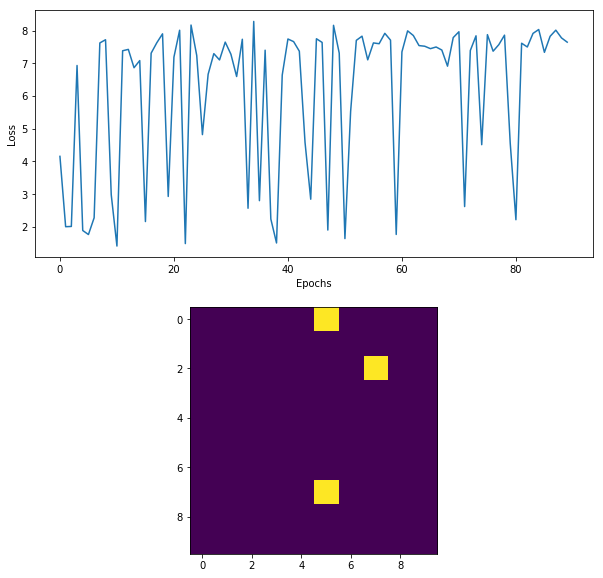

In [170]:
fig,ax = plt.subplots(2,1)
fig.set_size_inches(10,10)
ax[0].plot(np.array(losses).mean(axis=0))
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
print(grid.sum())
ax[1].imshow(grid)

# MF-Q with MAgent

In this case we don't have access to all the agent's initial action, so we need to sample an action from the policy
and compute mean actions based on that. And then repeat.

Need to write a function that finds all agents (grouped by team) within FOV using positions.

pseudocode:
```python
N := number of agents
t1 := team1 group
t2 := team2 group
a_means := randomly initialized action means of each agent
acts_1 := latest actions of each agent on team 1 (integers)
acts_2 := latest actions of each agent on team 2 
#action space is 21, so each action is a one-hot 21-vector
while not done:
   for i,agent in enumerate(t1): #get initial actions for each
        a_means[i] = neighborhood_mean(i)
        qvals = qfunc(obs[i],a_means[i])
        action = softmax_policy(qvals) #returns integer
        acts_1[i] = action
        
```

In [13]:
import magent
import math
from scipy.spatial.distance import cityblock

In [14]:
def get_neighbors(j,pos_list,r=6):
    """
    Given [x,y] positions of all agents in `pos_list`,
    return indices of agents that are within the radius of agent j (i.e. the j'th index in `pos_list`)
    """
    neighbors = []
    pos_j = pos_list[j]
    for i,pos in enumerate(pos_list):
        if i == j:
            continue
        dist = cityblock(pos,pos_j)
        if dist < r:
            neighbors.append(i)
    return neighbors

#get_neighbors(5,env.get_pos(team1))

In [15]:
def get_onehot(a,l=21):
    """
    Convert integer representation of action into one-hot vector representation
    """
    x = torch.zeros(21)
    x[a] = 1
    return x

def get_scalar(v):
    """
    Convert one-hot vector action into integer representation
    """
    return torch.argmax(v)

def get_mean_field(j,pos_list,act_list,r=7,l=21):
    """
    Get's the mean field action of agent `j`
    `pos_list` is what is returned by `env.get_pos(team1)`
    `l` is action space dimension
    """
    neighbors = get_neighbors(j,pos_list,r=r)
    mean_field = torch.zeros(l)
    for k in neighbors:
        act_ = act_list[k]
        act = get_onehot(act_)
        mean_field += act
    tot = mean_field.sum()
    mean_field = mean_field / tot if tot > 0 else mean_field
    return mean_field

In [16]:
def infer_acts(obs,param,layers,pos_list,acts,act_space=21,num_iter=5,temp=0.5):
    """
    Uses mean field Q_function parameterized by `param` and `layers` to sample actions
    for all agents using softmax policy.
    `obs` is observation tensor N x 13 x 13 x 2
    `mean_fields` is tensor containing all mean field actions for each agent N x 21
    `pos_list` is list of positions for each agent returned by `env.get_pos(...)`
    `acts` is vector of integer-represented actions of each agent (N,) [DEPRECATED]
    `num_iter` is number of times to alternative between action sampling and policy updates
    `temp` is softmax policy temperature to control exploration rate
    
    Returns:
        acts_: (N,) vector of integer actions sampled from policy
        mean_fields_: (N,21) tensor of mean field vectors for each agent
        qvals: (N,21) tensor of q values for each action for each agent
    """
    N = acts.shape[0]#,mean_fields.shape[1]
    mean_fields = torch.zeros(N,act_space)#mean_fields.clone() #clone to prevent in-place writes to input
    acts_ = acts.clone()#torch.zeros(N).long()#
    qvals = torch.zeros(N,act_space)
    if type(obs) == np.ndarray:
        obs = torch.from_numpy(obs)
    for i in range(num_iter): #alternate a few times to converge on policy
        for j in range(N):
            mean_fields[j] = get_mean_field(j,pos_list,acts_)
        for j in range(N):
            state = torch.cat((obs[j].flatten(),mean_fields[j]))
            qs = qfunc(state.detach(),param,layers=layers)
            qvals[j,:] = qs[:]
            acts_[j] = softmax_policy(qs.detach(),temp=temp)
    return acts_, mean_fields, qvals

In [17]:
def init_mean_field(N,act_space=21):
    mean_fields = torch.abs(torch.rand(N,act_space))
    for i in range(mean_fields.shape[0]):
        mean_fields[i] = mean_fields[i] / mean_fields[i].sum()
    return mean_fields

In [113]:
def train(batch_size,replay,param,layers,J=64,gamma=0.5,lr=0.001):
    """
    This function trains a single neural network using stored experiences
    in an experience replay memory buffer.
    
    `batch_size`, int
    `replay`, list of tuples (obs_1_small, acts_1,rewards1,act_means1,qnext1)
    `param`, vector, neural network parameter vector
    `layers`, list, contains shape of neural network layers,
    `J`, int,  number of agents on this team
    `gamma`, float in [0,1], discount factor
    `lr`, float, learning rate for SGD
    
    Returns loss (float)
    """
    ids = np.random.randint(low=0,high=len(replay),size=batch_size)
    exps = [replay[idx] for idx in ids]
    losses = []
    jobs = torch.stack([ex[0] for ex in exps]).detach() #stack
    jacts = torch.stack([ex[1] for ex in exps]).detach()
    jrewards = torch.stack([ex[2] for ex in exps]).detach()
    jmeans = torch.stack([ex[3] for ex in exps]).detach()
    vs = torch.stack([ex[4] for ex in exps]).detach()
    qs = []
    for h in range(batch_size):
        state = torch.cat((jobs[h].flatten(),jmeans[h]))
        qs.append(qfunc(state.detach(),param,layers=layers))
    qvals = torch.stack(qs)
    target = qvals.clone().detach()
    target[:,jacts] = jrewards + gamma * torch.max(vs,dim=1)[0] #20 = 20 + 20
    loss = torch.sum(torch.pow(qvals - target.detach(),2))
    losses.append(loss.detach().item())
    loss.backward()
    #SGD
    with torch.no_grad():
        param = param - lr * param.grad
    param.requires_grad = True
    return np.array(losses).mean()

In [93]:
hid_layer = 25
in_size = 359
act_space = 21
layers = [(in_size,hid_layer),(hid_layer,act_space)]
params = gen_params(2,in_size*hid_layer+hid_layer*act_space) #store parameter vector thetas for each Q-function
map_size = 30
width = height = map_size
n1 = n2 = 16
gap = 1
epochs = 10
replay_size = 70
batch_size = 25

In [120]:
# init the game "pursuit"  (config file are stored in python/magent/builtin/config/)
env = magent.GridWorld("battle", map_size=map_size) #each agent can see the 13x13 FOV around it (agent in center)
env.set_render_dir("MAgent/build/render")

# get group handles
team1, team2 = env.get_handles()
#action space is 21 discrete actions for each agent
#create custom positions
# left
side1 = int(math.sqrt(n1)) * 2
pos1 = []
for x in range(width//2 - gap - side1, width//2 - gap - side1 + side1, 2):
    for y in range((height - side1)//2, (height - side1)//2 + side1, 2):
        pos1.append([x, y, 0])

# right
side2 = int(math.sqrt(n2)) * 2
pos2 = []
for x in range(width//2 + gap, width//2 + gap + side2, 2):
    for y in range((height - side2)//2, (height - side2)//2 + side2, 2):
        pos2.append([x, y, 0])
        
# init env and agents
env.reset()
env.add_agents(team1, method="custom", pos=pos1)
env.add_agents(team2, method="custom", pos=pos2)

In [121]:
def team_step(team,param,acts,layers):
    """
    Returns acts, act_means, qvals, obs_small, ids
    """
    obs = env.get_observation(team)
    ids = env.get_agent_id(team)
     #only return group1 and group1 layers of observation
    obs_small = torch.from_numpy(obs[0][:,:,:,[1,4]])
    agent_pos = env.get_pos(team)
    acts, act_means, qvals = infer_acts(obs_small,\
                                       param,layers,agent_pos,acts)
    return acts, act_means, qvals, obs_small, ids

In [122]:
def add_to_replay(replay,obs_small, acts,rewards,act_means,qnext):
    """
    Given the experiences for all the agents on a team, add each individual agent's experience
    separately to the replay buffer.
    """
    for j in range(rewards.shape[0]): #loop through agents
        exp = (obs_small[j], acts[j],rewards[j],act_means[j],qnext[j])
        replay.append(exp)
        
    return replay

In [123]:
#%%time
N1 = env.get_num(team1)
N2 = env.get_num(team2)
step_ct = 0
print("nums: %d vs %d" % (N1, N2))
#initialize some things
acts_1 = torch.randint(low=0,high=act_space,size=(N1,))
acts_2 = torch.randint(low=0,high=act_space,size=(N2,))
# Two replays for two different models
replay1 = deque(maxlen=replay_size)
replay2 = deque(maxlen=replay_size)
#
qnext1 = torch.zeros(N1)
qnext2 = torch.zeros(N2)
#
act_means1 = init_mean_field(N1,act_space) #torch.zeros(N1,act_space)
act_means2 = init_mean_field(N2,act_space) #torch.zeros(N1,act_space)
#
rewards1 = torch.zeros(N1)
rewards2 = torch.zeros(N2)
#
losses1 = []
losses2 = []
for i in range(epochs):
    done = False
    while not done:
        # take actions for team 1

        acts_1, act_means1, qvals1, obs_small_1, ids_1 = team_step(team1,params[0],acts_1,layers)
        env.set_action(team1, acts_1.detach().numpy().astype(np.int32))

        # take actions for team 2

        acts_2, act_means2, qvals2, obs_small_2, ids_2 = team_step(team2,params[0],acts_2,layers)
        env.set_action(team2, acts_2.detach().numpy().astype(np.int32))

        # simulate one step
        done = env.step()
        
        # Get qnexts

        _, _, qnext1, _, ids_1 = team_step(team1,params[0],acts_1,layers)
        #
        _, _, qnext2, _, ids_2 = team_step(team2,params[0],acts_2,layers)

        # render
        env.render()

        # get reward
        rewards1 = torch.from_numpy(env.get_reward(team1)).float()
        rewards2 = torch.from_numpy(env.get_reward(team2)).float()
        reward = [sum(env.get_reward(team1)), sum(env.get_reward(team2))]
        
        #add to experience replay
        replay1 = add_to_replay(replay1, obs_small_1, acts_1,rewards1,act_means1,qnext1)
        replay2 = add_to_replay(replay2, obs_small_2, acts_2,rewards2,act_means2,qnext2)
        shuffle(replay1)
        shuffle(replay2)
        
        # clear dead agents
        ## after cleared agents, need to subset acts arrays
        ids_1_ = list(zip(np.arange(ids_1.shape[0]),ids_1))
        ids_2_ = list(zip(np.arange(ids_2.shape[0]),ids_2))
        #
        env.clear_dead()
        #
        ids_1  = env.get_agent_id(team1)
        ids_2  = env.get_agent_id(team2)
        #
        ids_1_ = [i for (i,j) in ids_1_ if j in ids_1]
        ids_2_ = [i for (i,j) in ids_2_ if j in ids_2]
        #
        acts_1 = acts_1[ids_1_]
        acts_2 = acts_2[ids_2_]
        
        # print info
        if step_ct % 10 == 0:
            print("epoch: {0} step: {1:.2f}\t team1' reward: {2:.2f}\t team2' reward: {3:.2f}".\
                                      format(i,step_ct, reward[0], reward[1]))

        step_ct += 1
        if i < 5 and step_ct > 250:
            break
            
        #training
        if len(replay1) > batch_size and len(replay2) > batch_size:
            #do training
            loss1 = train(batch_size,replay1,params[0],layers=layers) #train model1 for team1
            loss2 = train(batch_size,replay2,params[1],layers=layers) #train model2 for team2
            losses1.append(loss1)
            losses2.append(loss2)
            if step_ct % 10 == 0:
                print("Epoch: {0} \t Model 1 loss: {1:.2f} \t Model 2 loss: {2:.2f}".format(i,loss1,loss2))

nums: 16 vs 16
epoch: 0 step: 0.00	 team1' reward: -0.38	 team2' reward: -0.88
Epoch: 0 
 Model 1 loss: 16.17 
 Model 2 loss: 127.02
epoch: 0 step: 10.00	 team1' reward: -0.58	 team2' reward: -0.68
Epoch: 0 
 Model 1 loss: 53.27 
 Model 2 loss: 86.29
epoch: 0 step: 20.00	 team1' reward: -0.28	 team2' reward: -0.68
Epoch: 0 
 Model 1 loss: 30.84 
 Model 2 loss: 136.64
epoch: 0 step: 30.00	 team1' reward: -0.58	 team2' reward: -0.28
Epoch: 0 
 Model 1 loss: 66.54 
 Model 2 loss: 100.65
epoch: 0 step: 40.00	 team1' reward: -0.38	 team2' reward: -0.48
Epoch: 0 
 Model 1 loss: 48.02 
 Model 2 loss: 124.89
epoch: 0 step: 50.00	 team1' reward: -0.98	 team2' reward: -0.38
Epoch: 0 
 Model 1 loss: 33.26 
 Model 2 loss: 111.19
epoch: 0 step: 60.00	 team1' reward: -0.28	 team2' reward: -0.58
Epoch: 0 
 Model 1 loss: 49.56 
 Model 2 loss: 112.61
epoch: 0 step: 70.00	 team1' reward: -0.28	 team2' reward: -0.58
Epoch: 0 
 Model 1 loss: 18.07 
 Model 2 loss: 117.98
epoch: 0 step: 80.00	 team1' reward